## Description

This takes as input the root file containing the reco hits from DD4HEP and the output of the converter that produces the H5 file.  It makes some comparison histograms.  Ideally, the histograms will be identical.  Since the converter makes a few cuts on the hits, the cuts need to be applied here to the root data.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.colors as mcolors


from IPython.display import display_html 


from numpy import inf
import os

from os import listdir

import awkward as ak

import uproot3

import h5py as h5

### Set the input files here

In [2]:
input_root_file = 'insert_reco_pi-_50GeV_theta_2.83deg.edm4hep.root'

input_hdf5_file = 'insert_reco_pi-_50GeV_theta_2.83deg.edm4hep.hdf5'

nevents = 1000


hit_e_max = 1e10
hit_e_min = 0.06
hit_t_max = 200


In [3]:
ur_file = uproot3.open( input_root_file )

print( ur_file.keys() )

ur_tree = ur_file['events']

print( ur_tree )

ur_tree.show()

[b'events;141', b'events;140', b'events;139', b'metadata;1', b'run_metadata;1', b'evt_metadata;1', b'col_metadata;1']
<TTree b'events' at 0x7f1d28fc5d00>
HcalEndcapHitsDigi         TStreamerSTL               asdtype('>i4')
HcalEndcapHitsDigi.cellID  TStreamerBasicType         asjagged(asdtype('>u8'))
HcalEndcapHitsDigi.amplitude
                           TStreamerBasicType         asjagged(asdtype('>u8'))
HcalEndcapHitsDigi.timeStamp
                           TStreamerBasicType         asjagged(asdtype('>u8'))

HcalEndcapPHitsReco        TStreamerSTL               asdtype('>i4')
HcalEndcapPHitsReco.cellID TStreamerBasicType         asjagged(asdtype('>u8'))
HcalEndcapPHitsReco.energy TStreamerBasicType         asjagged(asdtype('>f4'))
HcalEndcapPHitsReco.energyError
                           TStreamerBasicType         asjagged(asdtype('>f4'))
HcalEndcapPHitsReco.time   TStreamerBasicType         asjagged(asdtype('>f4'))
HcalEndcapPHitsReco.timeError
                           TStream

In [4]:
h5_file = h5.File(input_hdf5_file,'r')

print(list(h5_file.keys()))

['hcal', 'hcali', 'mc']


In [5]:
short_to_branch_dict = {}
short_to_branch_dict['hcal'] = 'HcalEndcapPHitsReco'
short_to_branch_dict['hcali'] = 'HcalEndcapPInsertHitsReco'
short_to_branch_dict

{'hcal': 'HcalEndcapPHitsReco', 'hcali': 'HcalEndcapPInsertHitsReco'}

### Make a choice on which detector subsystem you want to look at.

In [6]:
group_to_check = 'hcali'
#group_to_check = 'hcal'

In [7]:
root_hits_x = ur_tree.array('%s.position.x' % short_to_branch_dict[group_to_check] , entrystop=nevents)
root_hits_y = ur_tree.array('%s.position.y' % short_to_branch_dict[group_to_check], entrystop=nevents)
root_hits_z = ur_tree.array('%s.position.z' % short_to_branch_dict[group_to_check], entrystop=nevents)
root_hits_e = ur_tree.array('%s.energy' % short_to_branch_dict[group_to_check], entrystop=nevents)
root_hits_t = ur_tree.array('%s.time' % short_to_branch_dict[group_to_check], entrystop=nevents)

root_hits_e = 1000*root_hits_e

In [8]:
h5_group = h5_file[group_to_check]

In [9]:
h5_hits_e = h5_group[:nevents,0]
h5_hits_x = h5_group[:nevents,1]
h5_hits_y = h5_group[:nevents,2]
h5_hits_z = h5_group[:nevents,3]

h5_hits_e = np.nan_to_num( h5_hits_e )
h5_hits_x = np.nan_to_num( h5_hits_x )
h5_hits_y = np.nan_to_num( h5_hits_y )
h5_hits_z = np.nan_to_num( h5_hits_z )

In [10]:
def make_comparison_plots( root_array, h5_array, var_name, yscale='log' ) :
    
    fig,ax = plt.subplots( 1, 2, figsize=(20, 9) )
    
    root_cuts = root_hits_e > hit_e_min
    root_cuts = np.logical_and( root_cuts, root_hits_e <= hit_e_max )
    root_cuts = np.logical_and( root_cuts, root_hits_t <= hit_t_max )
    
    root_hist = ax[0].hist( root_array[root_cuts].flatten(), bins=200 )
    h5_hist   = ax[1].hist( h5_array[h5_hits_e>0].flatten(), bins=200 )
    
    ax[0].set_yscale( yscale )
    ax[1].set_yscale( yscale )
    
    ax[0].set_title('Root', fontsize=21 )
    ax[1].set_title('H5', fontsize=21)
    
    ax[0].set_xlabel( var_name )
    ax[1].set_xlabel( var_name )
        
    plt.show()

    print("  array length:  %d" % len(root_hist[0]) )

    n_diffs = 0
    for bi in range( len(root_hist[0]) ):
        if root_hist[0][bi] == 0 and h5_hist[0][bi] == 0 : continue
        print( '%4d  :  %9.0f  %9.0f  %s' % (bi, root_hist[0][bi], h5_hist[0][bi],  root_hist[2][bi]), end='' )
        if root_hist[0][bi] != h5_hist[0][bi] :
            print(" *** %.0f" % (root_hist[0][bi] - h5_hist[0][bi]))
            n_diffs = n_diffs + 1
        else:
            print()

    print("\n\n Number of differences:  %d\n\n" % n_diffs )
    

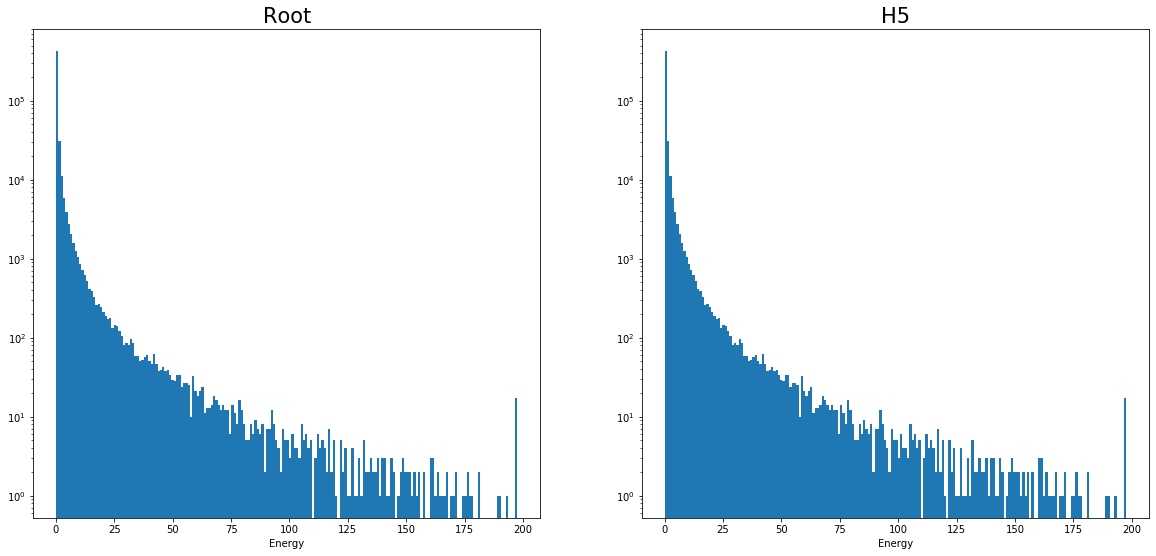

  array length:  200
   0  :     428612     428612  Rectangle(xy=(0.0610352, 0), width=0.987488, height=428612, angle=0)
   1  :      30649      30649  Rectangle(xy=(1.04852, 0), width=0.987488, height=30649, angle=0)
   2  :      11194      11194  Rectangle(xy=(2.03601, 0), width=0.987488, height=11194, angle=0)
   3  :       5819       5819  Rectangle(xy=(3.0235, 0), width=0.987488, height=5819, angle=0)
   4  :       3861       3861  Rectangle(xy=(4.01099, 0), width=0.987488, height=3861, angle=0)
   5  :       2769       2769  Rectangle(xy=(4.99847, 0), width=0.987488, height=2769, angle=0)
   6  :       2052       2052  Rectangle(xy=(5.98596, 0), width=0.987488, height=2052, angle=0)
   7  :       1563       1563  Rectangle(xy=(6.97345, 0), width=0.987488, height=1563, angle=0)
   8  :       1249       1249  Rectangle(xy=(7.96094, 0), width=0.987488, height=1249, angle=0)
   9  :       1059       1059  Rectangle(xy=(8.94843, 0), width=0.987488, height=1059, angle=0)
  10  :       

In [11]:
make_comparison_plots( root_hits_e, h5_hits_e, 'Energy' )

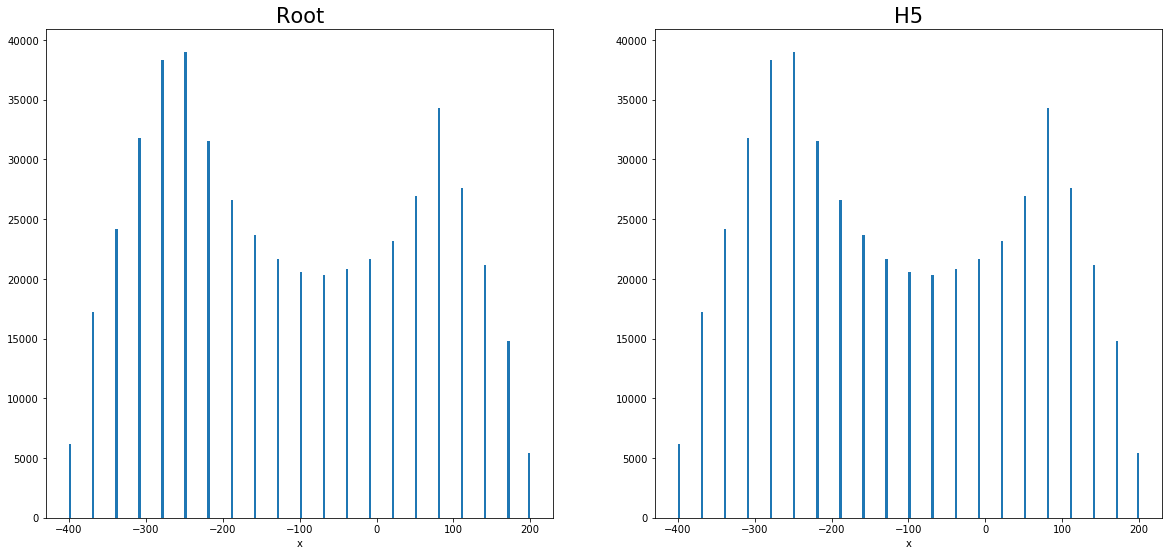

  array length:  200
   0  :       6190       6190  Rectangle(xy=(-400, 0), width=3, height=6190, angle=0)
  10  :      17227      17227  Rectangle(xy=(-370, 0), width=3, height=17227, angle=0)
  20  :      24210      24210  Rectangle(xy=(-340, 0), width=3, height=24210, angle=0)
  30  :      31764      31764  Rectangle(xy=(-310, 0), width=3, height=31764, angle=0)
  40  :      38340      38340  Rectangle(xy=(-280, 0), width=3, height=38340, angle=0)
  50  :      39001      39001  Rectangle(xy=(-250, 0), width=3, height=39001, angle=0)
  60  :      31533      31533  Rectangle(xy=(-220, 0), width=3, height=31533, angle=0)
  70  :      26621      26621  Rectangle(xy=(-190, 0), width=3, height=26621, angle=0)
  80  :      23691      23691  Rectangle(xy=(-160, 0), width=3, height=23691, angle=0)
  90  :      21652      21652  Rectangle(xy=(-130, 0), width=3, height=21652, angle=0)
 100  :      20556      20556  Rectangle(xy=(-100, 0), width=3, height=20556, angle=0)
 110  :      20320     

In [12]:
make_comparison_plots( root_hits_x, h5_hits_x, 'x', 'linear' )

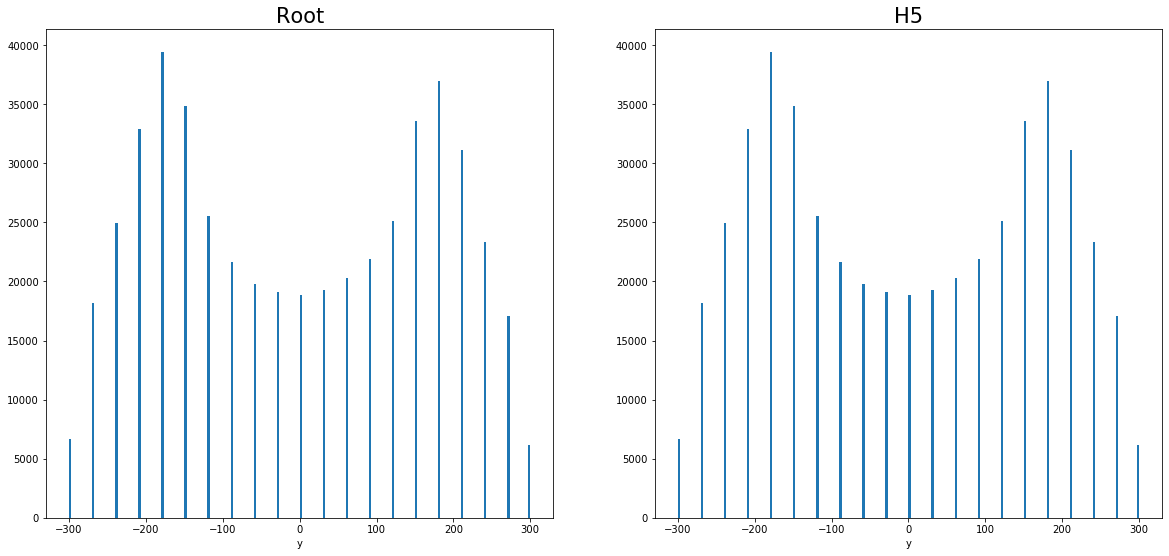

  array length:  200
   0  :       6706       6706  Rectangle(xy=(-300, 0), width=3, height=6706, angle=0)
  10  :      18152      18152  Rectangle(xy=(-270, 0), width=3, height=18152, angle=0)
  20  :      24974      24974  Rectangle(xy=(-240, 0), width=3, height=24974, angle=0)
  30  :      32912      32912  Rectangle(xy=(-210, 0), width=3, height=32912, angle=0)
  40  :      39435      39435  Rectangle(xy=(-180, 0), width=3, height=39435, angle=0)
  50  :      34888      34888  Rectangle(xy=(-150, 0), width=3, height=34888, angle=0)
  60  :      25577      25577  Rectangle(xy=(-120, 0), width=3, height=25577, angle=0)
  70  :      21680      21680  Rectangle(xy=(-90, 0), width=3, height=21680, angle=0)
  80  :      19811      19811  Rectangle(xy=(-60, 0), width=3, height=19811, angle=0)
  90  :      19094      19094  Rectangle(xy=(-30, 0), width=3, height=19094, angle=0)
 100  :      18896      18896  Rectangle(xy=(0, 0), width=3, height=18896, angle=0)
 110  :      19251      19251

In [13]:
make_comparison_plots( root_hits_y, h5_hits_y, 'y', 'linear' )

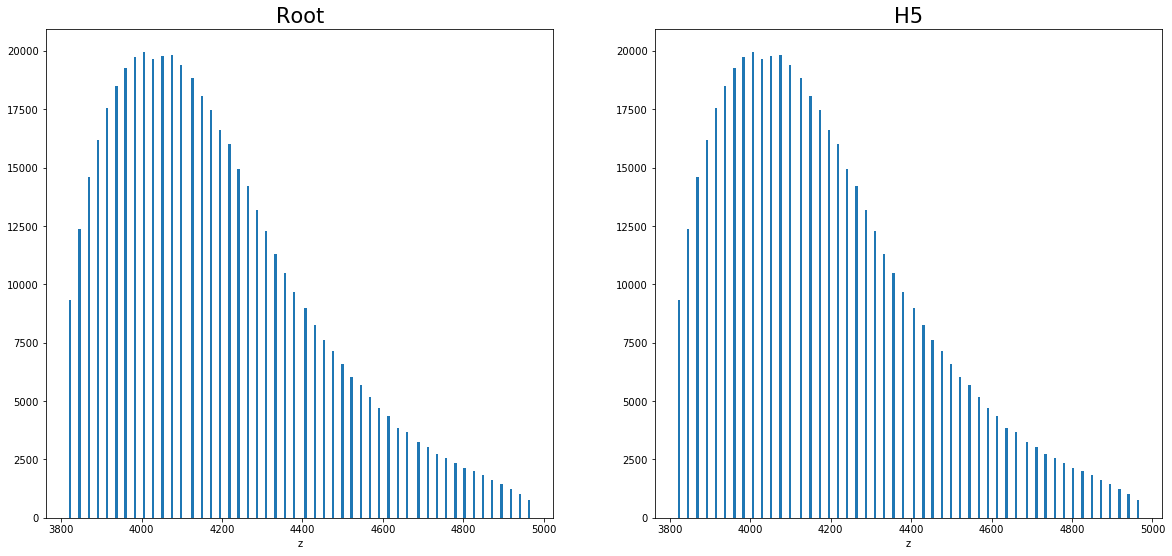

  array length:  200
   0  :       9333       9333  Rectangle(xy=(3819.95, 0), width=5.73291, height=9333, angle=0)
   4  :      12366      12366  Rectangle(xy=(3842.88, 0), width=5.73315, height=12366, angle=0)
   8  :      14572      14572  Rectangle(xy=(3865.81, 0), width=5.73291, height=14572, angle=0)
  12  :      16159      16159  Rectangle(xy=(3888.75, 0), width=5.73315, height=16159, angle=0)
  16  :      17545      17545  Rectangle(xy=(3911.68, 0), width=5.73291, height=17545, angle=0)
  20  :      18470      18470  Rectangle(xy=(3934.61, 0), width=5.73315, height=18470, angle=0)
  24  :      19266      19266  Rectangle(xy=(3957.54, 0), width=5.73291, height=19266, angle=0)
  28  :      19750      19750  Rectangle(xy=(3980.47, 0), width=5.73315, height=19750, angle=0)
  32  :      19952      19952  Rectangle(xy=(4003.41, 0), width=5.73291, height=19952, angle=0)
  36  :      19667      19667  Rectangle(xy=(4026.34, 0), width=5.73315, height=19667, angle=0)
  40  :      19796  

In [14]:
make_comparison_plots( root_hits_z, h5_hits_z, 'z', 'linear' )